In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 20, 5
pd.set_option('display.max_columns', None)
import math
from scipy.integrate import odeint
import matplotlib.animation
from IPython.display import Image, HTML, display
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
def save_animation(data, left_column, left_colors, right_columns, right_colors, name, legend_loc='upper right'):
    fig, ax = plt.subplots()
    fig.set_size_inches(w=15, h=7)

    left_lines = [ax.plot(data.index, data[l], color=c, label=l)[0] for l, c in zip(left_columns, left_colors)]

    ax_right = ax.twinx()
    right_lines = [ax_right.plot(data.index, data[l], color=c, label=l)[0] for l, c in zip(right_columns, right_colors)]

    lines = left_lines + right_lines
    columns = left_columns + right_columns
    ax.legend(lines, columns, loc=legend_loc)

    plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.94)
    # todo try fig.tight_layout()

    plt.title(name, fontsize=30)
    plt.savefig('img-generated/' + name + '.png', dpi=100)

    animate = lambda i: [line.set_data(data.index[:i], data[column].iloc[:i]) 
                         for (line, column) in zip(lines, columns)]

    frames = np.linspace(0, data.shape[0] - 1, 125, dtype=np.int)
    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=frames, interval=40)

    ani.save('img-generated/' + name + '.gif', writer="imagemagick", dpi=100, fps=25)

mash tun dimensions

In [3]:
radius = 0.15
height = 0.75

In [4]:
volume = math.pi * math.pow(radius, 2) * height
volume

0.053014376029327764

In [5]:
surface = 2 * math.pi * radius * height + 2 * math.pi * math.pow(radius, 2)
surface

0.8482300164692441

In [6]:
# specific heat https://en.wikipedia.org/wiki/Heat_capacity#Measurement
# in J/(kg⋅K)
Cp = 3000
heat_capacity = Cp * volume * 1000

# air convection, in W/(m^2*K)
heat_transfer_coefficient = 30

In [7]:
# ambient heat loss in Watts
heat_transfer_coefficient * surface * (75 - 25)

1272.345024703866

In [8]:
# time to heat to target temperature (seconds)
heat_capacity * (75 - 50) / 3000

1325.3594007331942

In [9]:
# https://en.wikipedia.org/wiki/Newton%27s_law_of_cooling
def temperature_derivative(temperature, time, power, external_temperature, 
                  heat_capacity, heat_transfer_coefficient, surface):
    return (power - heat_transfer_coefficient * surface * (temperature - external_temperature)) / heat_capacity

### heat cool

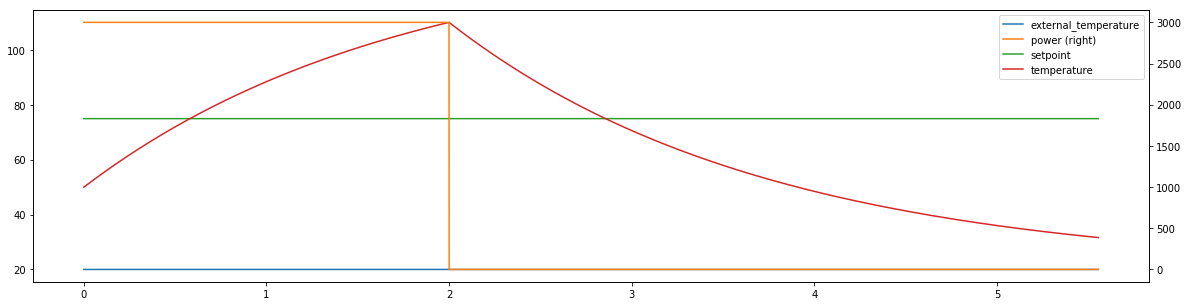

In [10]:
time = np.arange(0, 20000, 1, dtype=np.float64)
power = np.full_like(time, 3000)
power[7200:] = 0
external_temperature = np.full_like(time, 20)
temperature = np.full_like(time, np.nan)
temperature[0] = 50
setpoint = np.full_like(time, 75)

for i in range(len(time) - 1):
    temperature[i+1] = odeint(temperature_derivative, temperature[i], time[i:(i+2)], 
                              args=(power[i+1], external_temperature[i], heat_capacity, 
                                    heat_transfer_coefficient, surface),
                             )[-1]

data = pd.DataFrame(index=time / 3600, data={'temperature':  temperature,
                               'external_temperature': external_temperature,
                               'setpoint': setpoint,
                               'power': power
                              })
data.plot(secondary_y=('power'));

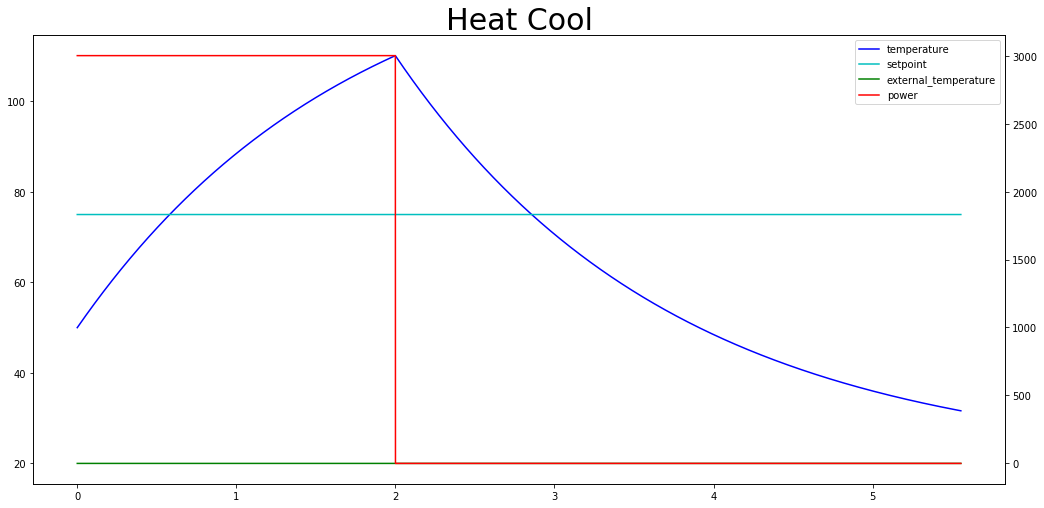

In [11]:
left_columns = ['temperature', 'setpoint', 'external_temperature']
left_colors = ['b', 'c', 'g']

right_columns = ['power']
right_colors = ['r']

save_animation(data, left_columns, left_colors, right_columns, right_colors, 'Heat Cool')

### relay controller

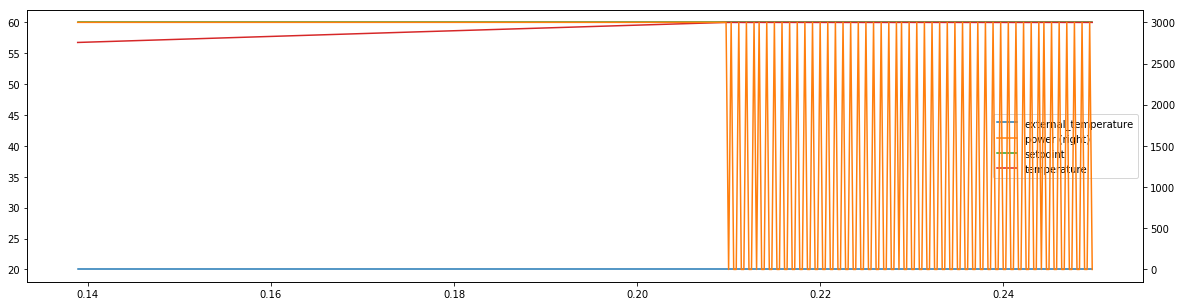

In [12]:
time = np.arange(0, 1500, 1, dtype=np.float64)
power = np.full_like(time, 3000)
external_temperature = np.full_like(time, 20)
temperature = np.full_like(time, np.nan)
temperature[0] = 50
setpoint = np.full_like(time, 60)

for i in range(len(time) - 1):
    if (temperature[i] < setpoint[i]):
        power[i+1] = 3000
    else:
        power[i+1] = 0
    temperature[i+1] = odeint(temperature_derivative, temperature[i], time[i:(i+2)], 
                              args=(power[i+1], external_temperature[i], heat_capacity, 
                                    heat_transfer_coefficient, surface),
                             )[-1]

data = pd.DataFrame(index=time / 3600, data={'temperature':  temperature,
                               'external_temperature': external_temperature,
                               'setpoint': setpoint,
                               'power': power
                              })
data.iloc[500:900].plot(secondary_y=('power'));

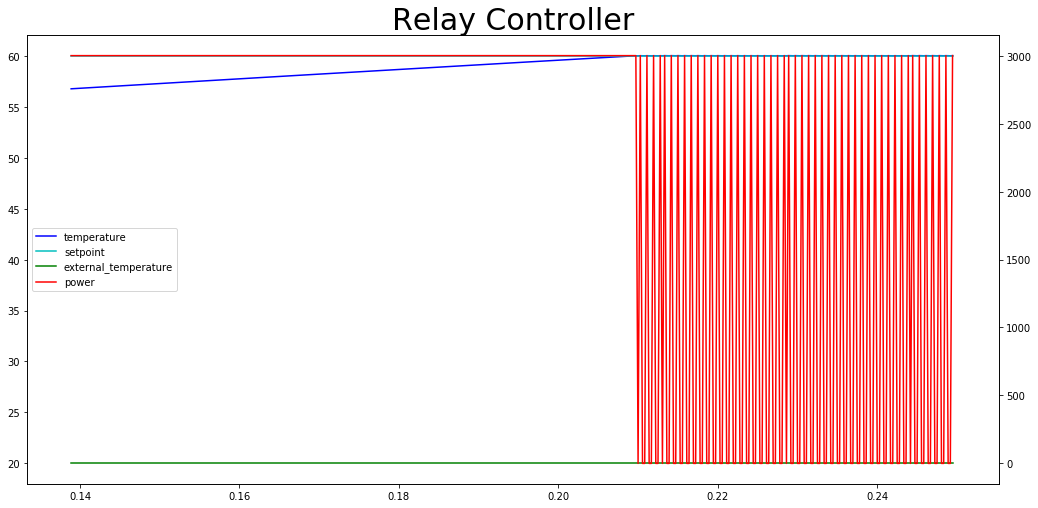

In [13]:
left_columns = ['temperature', 'setpoint', 'external_temperature']
left_colors = ['b', 'c', 'g']

right_columns = ['power']
right_colors = ['r']

save_animation(data.iloc[500:900], left_columns, left_colors, right_columns, right_colors, 
               'Relay Controller', 'center left')

### relay delay

In [14]:
time = np.arange(0, 1500, 1, dtype=np.float64)
power = np.full_like(time, 3000)
external_temperature = np.full_like(time, 20)
temperature = np.full_like(time, np.nan)
temperature[0] = 50
setpoint = np.full_like(time, 60)

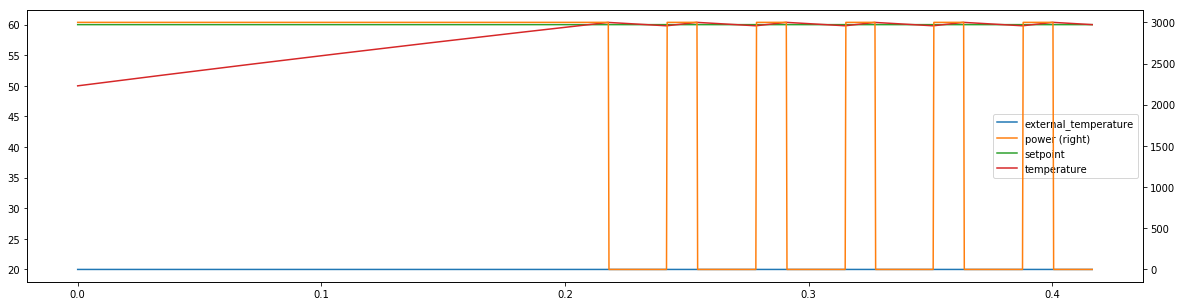

In [15]:
for i in range(len(time) - 1):
    if i + 30 < len(time):
        if temperature[i] < setpoint[i]:
            power[i + 30] = 3000
        else:
            power[i + 30] = 0
    temperature[i+1] = odeint(temperature_derivative, temperature[i], time[i:(i+2)], 
                              args=(power[i+1], external_temperature[i], heat_capacity, 
                                    heat_transfer_coefficient, surface),
                             )[-1]

data = pd.DataFrame(index=time / 3600, data={'temperature':  temperature,
                               'external_temperature': external_temperature,
                               'setpoint': setpoint,
                               'power': power
                              })
data.plot(secondary_y=('power'));

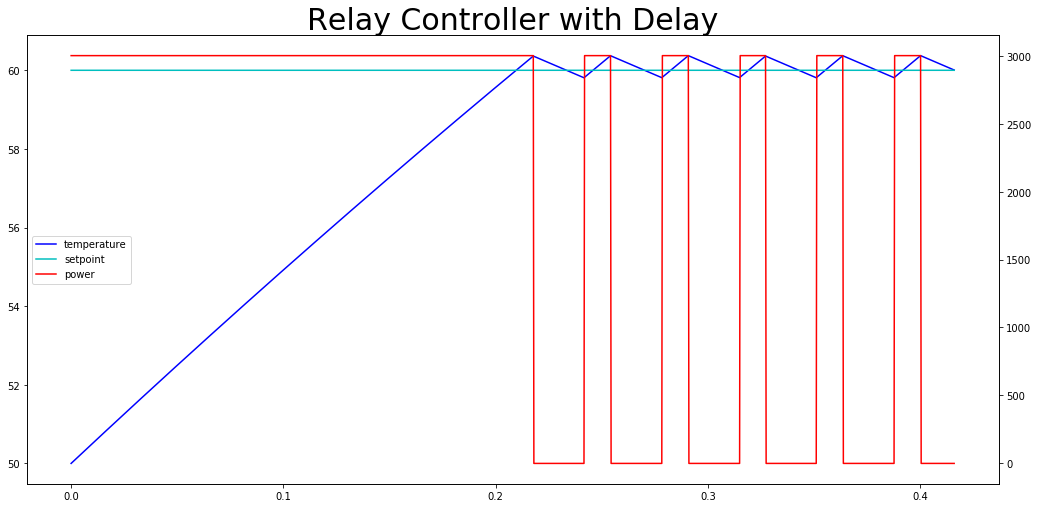

In [16]:
left_columns = ['temperature', 'setpoint']
left_colors = ['b', 'c']

right_columns = ['power']
right_colors = ['r']

save_animation(data, left_columns, left_colors, right_columns, right_colors, 
               'Relay Controller with Delay', 'center left')

### high power slow relay

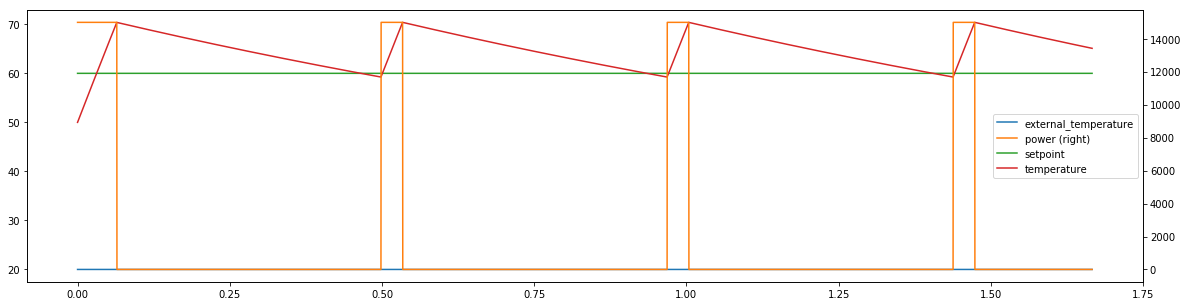

In [17]:
time = np.arange(0, 6000, 1, dtype=np.float64)
max_power = 15000
power = np.full_like(time, max_power)
external_temperature = np.full_like(time, 20)
temperature = np.full_like(time, np.nan)
temperature[0] = 50
setpoint = np.full_like(time, 60)
delay = 120

for i in range(len(time) - 1):
    if temperature[i] < setpoint[i]:
        next_power = max_power
    else:
        next_power = 0
    if i + delay < len(time):
        power[i + delay] = next_power
    temperature[i+1] = odeint(temperature_derivative, temperature[i], time[i:(i+2)], 
                              args=(power[i+1], external_temperature[i], heat_capacity, 
                                    heat_transfer_coefficient, surface),
                             )[-1]

data = pd.DataFrame(index=time / 3600, data={'temperature':  temperature,
                               'external_temperature': external_temperature,
                               'setpoint': setpoint,
                               'power': power
                              })
data.plot(secondary_y=('power'));

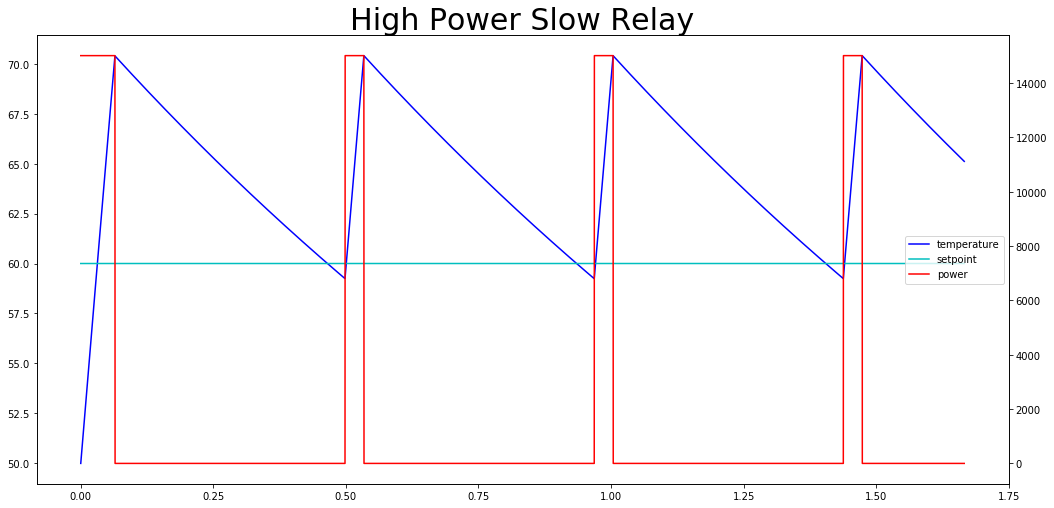

In [18]:
left_columns = ['temperature', 'setpoint']
left_colors = ['b', 'c']

right_columns = ['power']
right_colors = ['r']

save_animation(data, left_columns, left_colors, right_columns, right_colors, 
               'High Power Slow Relay', 'center right')

### meet P from PID

In [19]:
def proportional_controller(proportional):
    time = np.arange(0, 6000, 1, dtype=np.float64)
    max_power = 15000
    power = np.full_like(time, 3000)
    external_temperature = np.full_like(time, 20)
    temperature = np.full_like(time, np.nan)
    temperature[0] = 50
    setpoint = np.full_like(time, 60)
    delay = 120
    error = np.zeros_like(time)

    for i in range(len(time) - 1):
        error[i] = temperature[i] - setpoint[i]
        next_power = - proportional * error[i]
        if i + delay < len(time):
            power[i + delay] = next_power
        temperature[i+1] = odeint(temperature_derivative, temperature[i], time[i:(i+2)], 
                                  args=(power[i+1], external_temperature[i], heat_capacity, 
                                        heat_transfer_coefficient, surface),
                                 )[-1]

    data = pd.DataFrame(index=time / 3600, data={'temperature':  temperature,
                                   'external_temperature': external_temperature,
                                   'setpoint': setpoint,
                                   'power': power,
                                   'error': error
                                  })
    data.plot(secondary_y=('power'))
    plt.show()
    return data

display(interactive(proportional_controller, proportional=widgets.FloatSlider(min=1, max=2500, value=1000)))

Widget Javascript not detected.  It may not be installed or enabled properly.


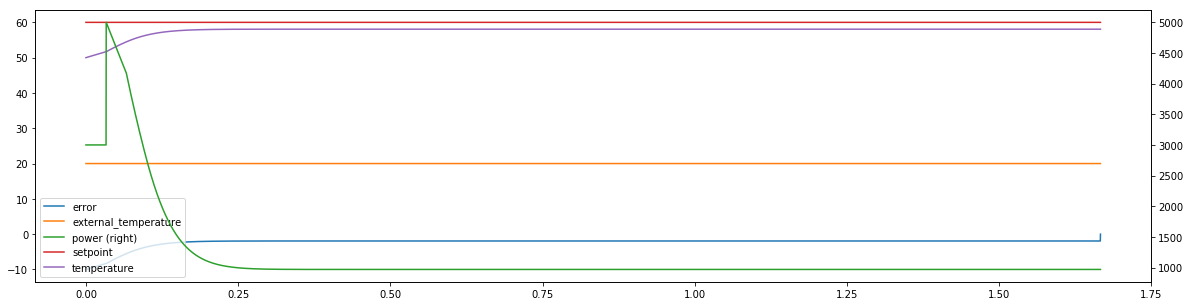

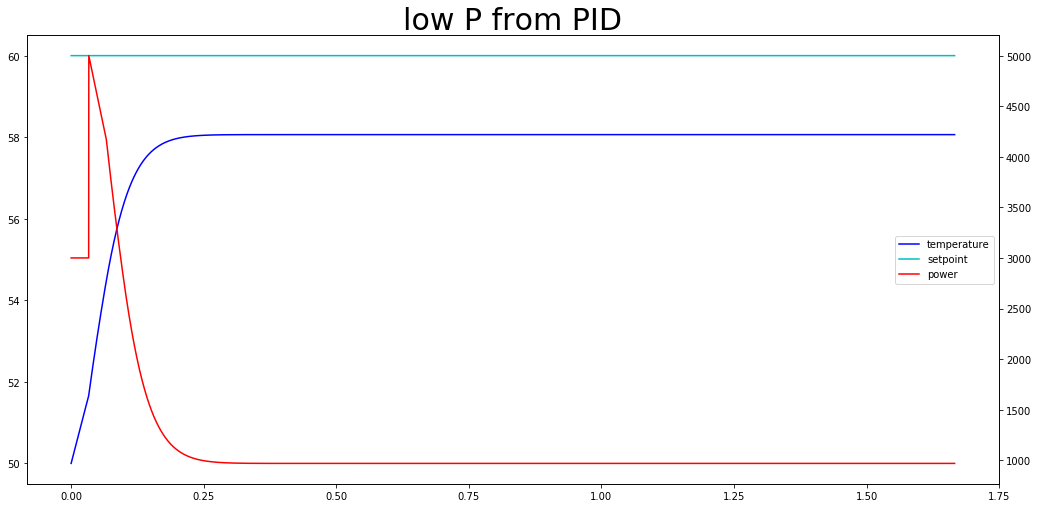

In [20]:
left_columns = ['temperature', 'setpoint']
left_colors = ['b', 'c']

right_columns = ['power']
right_colors = ['r']

save_animation(proportional_controller(500), left_columns, left_colors, right_columns, right_colors, 
               'low P from PID', 'center right')

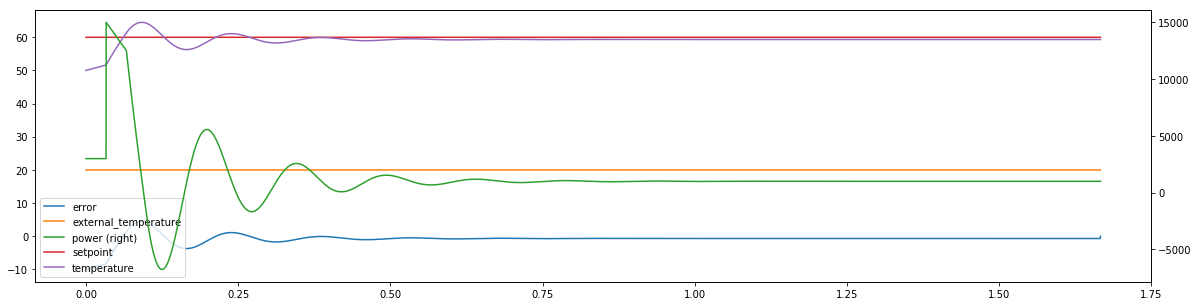

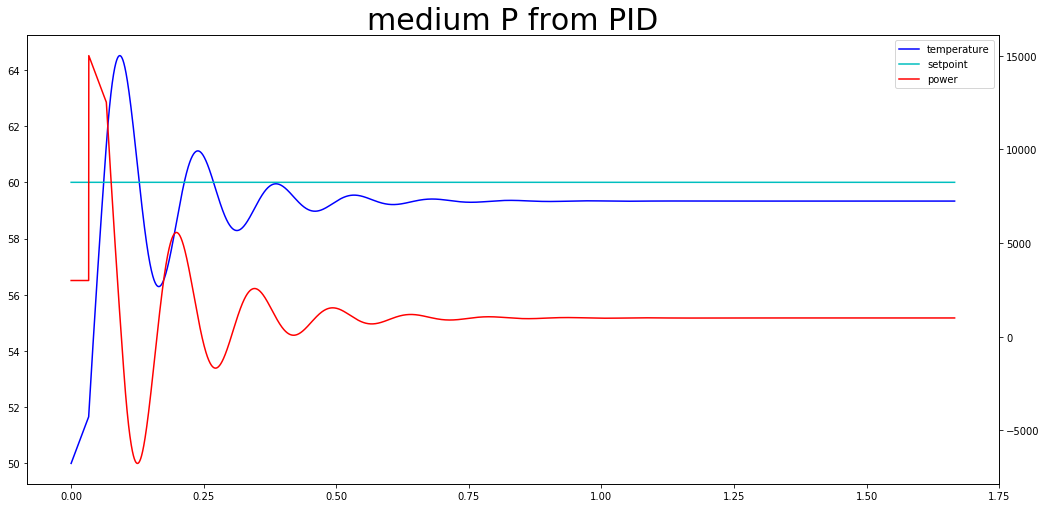

In [21]:
save_animation(proportional_controller(1500), left_columns, left_colors, right_columns, right_colors, 
               'medium P from PID', 'upper right')

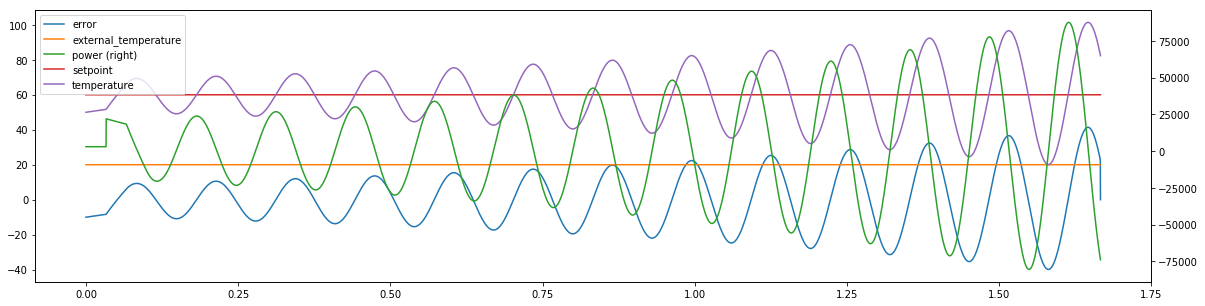

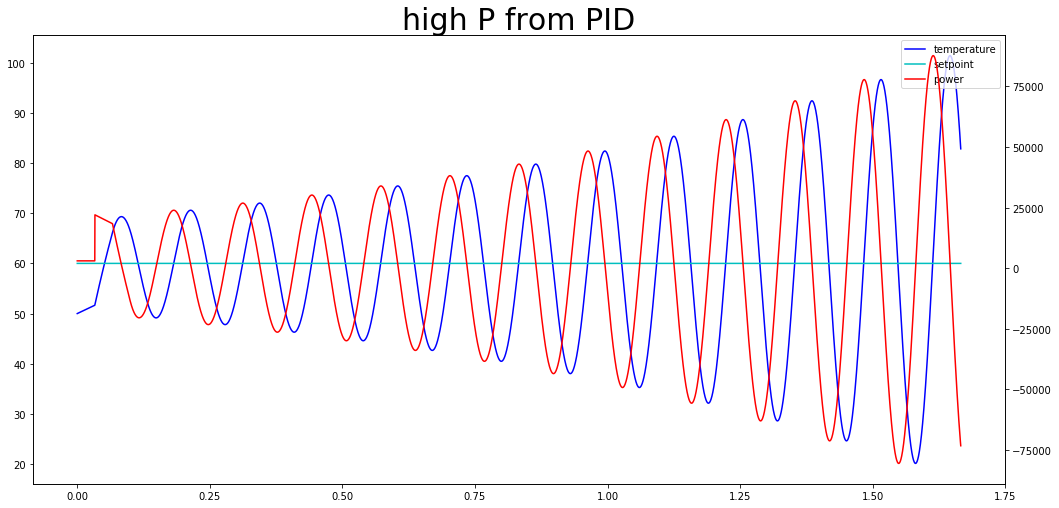

In [22]:
save_animation(proportional_controller(2200), left_columns, left_colors, right_columns, right_colors, 
               'high P from PID', 'upper right')

In [23]:
def proportional_limited(proportional):
    time = np.arange(0, 12000, 1, dtype=np.float64)
    max_power = 15000
    power = np.full_like(time, 3000)
    external_temperature = np.full_like(time, 20)
    temperature = np.full_like(time, np.nan)
    temperature[0] = 50
    setpoint = np.full_like(time, 60)
    delay = 120
    error = np.zeros_like(time)

    for i in range(len(time) - 1):
        error[i] = temperature[i] - setpoint[i]
        next_power = - proportional * error[i]
        if next_power > max_power:
            next_power = max_power
        elif next_power < 0:
            next_power = 0
        if i + delay < len(time):
            power[i + delay] = next_power
        temperature[i+1] = odeint(temperature_derivative, temperature[i], time[i:(i+2)], 
                                  args=(power[i+1], external_temperature[i], heat_capacity, 
                                        heat_transfer_coefficient, surface),
                                 )[-1]

    data = pd.DataFrame(index=time / 3600, data={'temperature':  temperature,
                                   'external_temperature': external_temperature,
                                   'setpoint': setpoint,
                                   'power': power,
                                   'error': error
                                  })
    data.plot(secondary_y=('power'))
    plt.show()
    return data

display(interactive(proportional_limited, proportional=widgets.FloatSlider(min=1, max=10000, value=1800)))

Widget Javascript not detected.  It may not be installed or enabled properly.


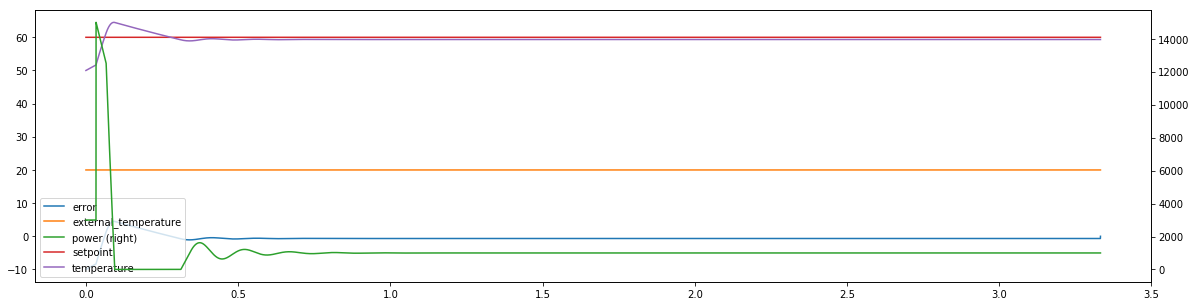

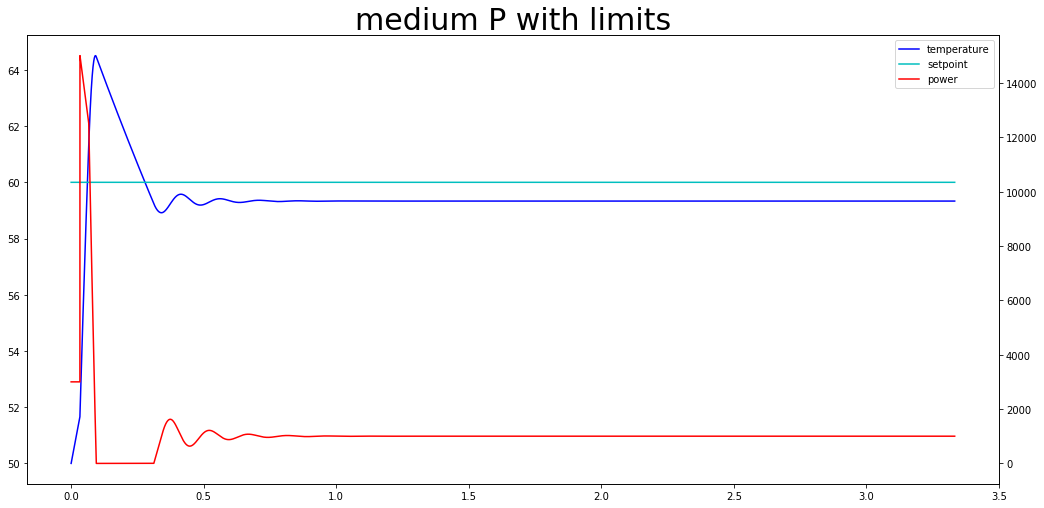

In [24]:
save_animation(proportional_limited(1500), left_columns, left_colors, right_columns, right_colors, 
               'medium P with limits', 'upper right')

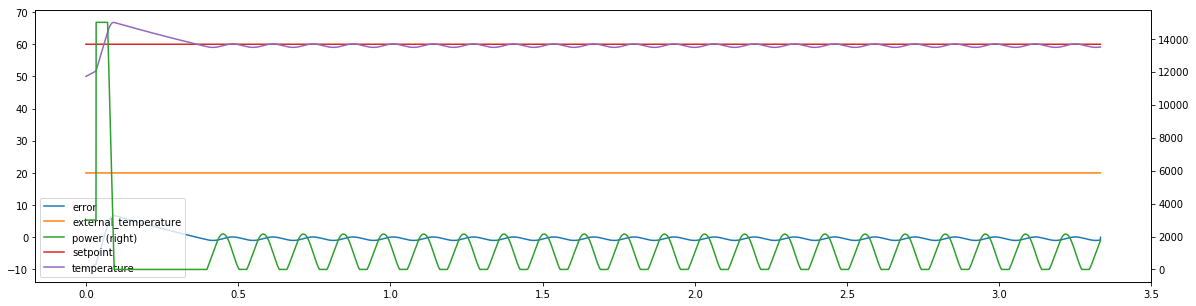

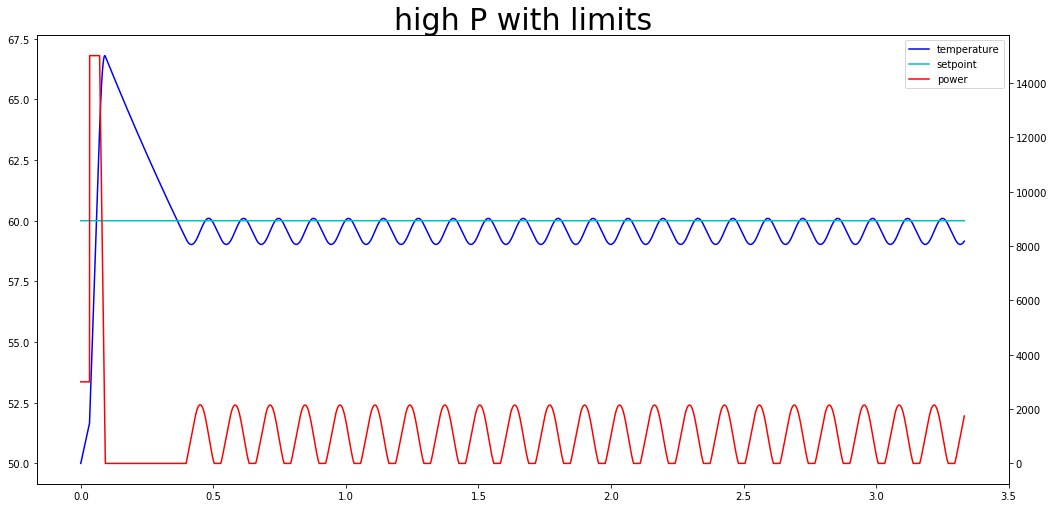

In [25]:
save_animation(proportional_limited(2200), left_columns, left_colors, right_columns, right_colors, 
               'high P with limits', 'upper right')

### proportional integral

In [52]:
def proportional_integral(proportional, integral, max_time, clip_range):
    time = np.arange(0, max_time, 1, dtype=np.float64)
    max_power = 15000
    power = np.full_like(time, 3000)
    external_temperature = np.full_like(time, 20)
    temperature = np.full_like(time, np.nan)
    temperature[0] = 50
    setpoint = np.full_like(time, 60)
    delay = 120
    error = np.zeros_like(time)
    integral_error = np.zeros_like(time)

    for i in range(len(time) - 1):
        error[i] = temperature[i] - setpoint[i]
        time_diff = time[i + 1] - time[i]
        if i >= 1:
            integral_error[i] = integral_error[i-1] + error[i] * time_diff
        next_power = - proportional * error[i] - integral * integral_error[i]
        if next_power > max_power and clip_range:
            next_power = max_power
        elif next_power < 0 and clip_range:
            next_power = 0
        if i + delay < len(time):
            power[i + delay] = next_power
        temperature[i+1] = odeint(temperature_derivative, temperature[i], time[i:(i+2)], 
                                  args=(power[i+1], external_temperature[i], heat_capacity, 
                                        heat_transfer_coefficient, surface),
                                 )[-1]

    data = pd.DataFrame(index=time / 3600, data={'temperature':  temperature,
                                   'external_temperature': external_temperature,
                                   'setpoint': setpoint,
                                   'power': power,
                                   #'integral_error': integral_error
                                  })
    data.plot(secondary_y=('power'))
    plt.show()
    return data

display(interactive(proportional_integral,
                    max_time=widgets.IntSlider(min=3000, max=7200, step=100, value=7200),
                    clip_range=widgets.Checkbox(value=False),
                    proportional=widgets.FloatSlider(min=0, max=2200, step=10, value=800),
                    integral=widgets.FloatSlider(min=0.0, max=10.0, value=2)))

In [45]:
def proportional_integral_windup(proportional, integral, max_time):
    time = np.arange(0, max_time, 1, dtype=np.float64)
    max_power = 15000
    power = np.full_like(time, 3000)
    external_temperature = np.full_like(time, 20)
    temperature = np.full_like(time, np.nan)
    temperature[0] = 50
    setpoint = np.full_like(time, 60)
    delay = 120
    error = np.zeros_like(time)
    integral_error = np.zeros_like(time)

    for i in range(len(time) - 1):
        error[i] = temperature[i] - setpoint[i]
        time_diff = time[i + 1] - time[i]
        if i >= 1:
            integral_error[i] = integral_error[i-1] + error[i] * time_diff
        next_power = - proportional * error[i] - integral * integral_error[i]
        if next_power > max_power:
            next_power = max_power
            integral_error[i] = integral_error[i-1]
        elif next_power < 0:
            next_power = 0
            integral_error[i] = integral_error[i-1]
        if i + delay < len(time):
            power[i + delay] = next_power
        temperature[i+1] = odeint(temperature_derivative, temperature[i], time[i:(i+2)], 
                                  args=(power[i+1], external_temperature[i], heat_capacity, 
                                        heat_transfer_coefficient, surface),
                                 )[-1]

    data = pd.DataFrame(index=time / 3600, data={'temperature':  temperature,
                                   'external_temperature': external_temperature,
                                   'setpoint': setpoint,
                                   'power': power,
                                   #'integral_error': integral_error
                                  })
    data.plot(secondary_y=('power'))
    plt.show()
    return data

display(interactive(proportional_integral_windup, 
                    max_time=widgets.IntSlider(min=3000, max=36000, value=12000),
                    proportional=widgets.FloatSlider(min=0, max=1500, value=0),
                    integral=widgets.FloatSlider(min=0.0, max=10.0, value=0.5),
                    ))